https://www.cienciadedatos.net/documentos/py09_gradient_boosting_python

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from scipy.stats import randint
import multiprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# Bayesian
# ==============================================================================
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold
from sklearn.metrics import classification_report
import xgboost as xgb
from collections import Counter
import time
import optuna
from optuna.samplers import TPESampler
from sklearn.datasets import make_classification

# Bayesian Multiobjetivo
# ==============================================================================
import pickle
import sys
import warnings

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Gradient Boosting Classifier
# ==============================================================================
from sklearn.ensemble import GradientBoostingClassifier

/Users/savkaaldunce/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#carga los datos
tabla_final = pd.read_csv('correlaciones/tabla_entrega_final.csv', sep = ",")

## Definimos una tabla con los id de clientes
## Para luego poeder funtarla con las prob ##
## Si se queda se considera como parametro ##
tabla_con_id_cliente = tabla_final

tabla_final = tabla_final.drop('ID_CLIENTE', axis=1)
#visualizamos los datos
tabla_final

,ANTIGUEDAD,FLAG_ACTIVI,ID_ESTADO,ACEPTADO,CT_CTE,DEBITO_DIR,Suma,RENTA,EDAD,ID_GENERO,ID_REGION_RESIDE
0,6.0,1.0,0.0,0.0,1,0,1,87218.10,36.0,1.0,0.0
1,35.0,0.0,1.0,0.0,1,0,1,122179.11,23.0,0.0,0.0
2,35.0,0.0,1.0,0.0,0,0,1,119775.54,23.0,1.0,0.0
3,35.0,0.0,1.0,0.0,1,0,1,22220.04,24.0,1.0,0.0
4,35.0,0.0,1.0,0.0,1,0,1,295590.36,24.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
602519,62.0,0.0,1.0,0.0,0,0,0,97397.16,41.0,1.0,1.0
602520,7.0,0.0,1.0,0.0,0,0,0,168445.62,34.0,0.0,0.0
602521,6.0,0.0,1.0,0.0,0,0,0,53689.02,24.0,1.0,1.0
602522,229.0,0.0,1.0,0.0,0,0,0,64404.21,61.0,0.0,0.0


In [77]:
# Split the data into features (X) and target (y)
X = tabla_final.drop('ACEPTADO', axis=1)
y = tabla_final['ACEPTADO']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [80]:
# Bayesian Multiobjetivo
# ==============================================================================
def train(trial):
    
    max_depth = trial.suggest_int('max_depth', 5, X_train.shape[1]) #profundidad máxima del árbol
    n_estimators=trial.suggest_int('n_estimators',125, 200) #número de ramas en el árbol
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20) #mínimo de muestras en el nodo para que se pueda dividir
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20) #mínimo de muestras en un nodo para que sea considerado una hoja
    min_impurity_decrease  = trial.suggest_float('min_impurity_decrease', 0, 1) #mínimo para supervisar si es necesario separar un nodo.
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1) #tasa de aprendizaje
    # learnign rate mas baja --> mejores resultados
    # ccp alpha --> regula la complejidad del modelo 

    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", GradientBoostingClassifier(max_depth = max_depth, n_estimators = n_estimators, min_samples_split= min_samples_split, min_samples_leaf=min_samples_leaf, min_impurity_decrease=min_impurity_decrease, learning_rate=learning_rate, random_state=22))
    ])
    
    pipeline.fit(X_train, y_train)
    score = cross_val_score(pipeline, X_train, y_train, scoring='accuracy',
                            cv=4).mean()
    y_pred = pipeline.predict(X_test)
    recall = recall_score(y_test, y_pred)
    

    return score, recall


motpe_sampler = optuna.samplers.MOTPESampler()
motpe_experiment = optuna.create_study(sampler=motpe_sampler, directions=['maximize', 'maximize'])
motpe_experiment.optimize(train, n_trials=20)

/var/folders/cc/3mg7xtb906vcdzf2brdmqt500000gn/T/ipykernel_4520/758745506.py:30: FutureWarning: MOTPESampler has been deprecated in v2.9.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.9.0.
  motpe_sampler = optuna.samplers.MOTPESampler()
[I 2023-06-26 00:12:27,998] A new study created in memory with name: no-name-bbbd61d1-9a21-411b-9f05-7013cd69c4d4
[I 2023-06-26 00:15:24,078] Trial 0 finished with values: [0.9433051390272634, 0.4352343308865048] and parameters: {'max_depth': 5, 'n_estimators': 164, 'min_samples_split': 3, 'min_samples_leaf': 16, 'min_impurity_decrease': 0.7294774645971132, 'learning_rate': 0.0763940836126061}. 
[I 2023-06-26 00:22:44,253] Trial 1 finished with values: [0.942894366433203, 0.4261998870694523] and parameters: {'max_depth': 10, 'n_estimators': 178, 'min_samples_split': 5, 'min_samples_leaf': 18, 'min_impurity_decrease': 0.3843153998549028, 'learning_rate': 0.020287733412489368}. 
[I 2023-06-26 00:26:54,667]

In [81]:
def cast_as_df(optuna_experiment, experiment_type):
    df = (
        optuna_experiment
        .trials_dataframe()
        .rename(columns={"values_0": "accuracy", "values_1": "sensibilidad"})
        .assign(experiment = experiment_type)
    )
    # the following lines create a column identifing which of the trials resulted in a
    # Best configuration -- a model with these HPs lies along the empirical Pareto frontier
    best_trials = [trial.number for trial in optuna_experiment.best_trials]
    df['best_trial'] = np.where(df.number.isin(best_trials), 1, 0)
    return df

motpe_df = cast_as_df(motpe_experiment, "MOTPE")
motpe_df

,number,accuracy,sensibilidad,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_min_impurity_decrease,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state,experiment,best_trial
0,0,0.943305,0.435234,2023-06-26 00:12:27.999247,2023-06-26 00:15:24.078437,0 days 00:02:56.079190,0.076394,5,0.729477,16,3,164,COMPLETE,MOTPE,0
1,1,0.942894,0.426200,2023-06-26 00:15:24.079997,2023-06-26 00:22:44.253299,0 days 00:07:20.173302,0.020288,10,0.384315,18,5,178,COMPLETE,MOTPE,0
2,2,0.942919,0.443365,2023-06-26 00:22:44.254905,2023-06-26 00:26:54.666787,0 days 00:04:10.411882,0.051306,10,0.478924,15,16,188,COMPLETE,MOTPE,1
3,3,0.943133,0.438283,2023-06-26 00:26:54.668195,2023-06-26 00:29:54.818918,0 days 00:03:00.150723,0.055611,10,0.970090,9,17,134,COMPLETE,MOTPE,0
4,4,0.942795,0.395935,2023-06-26 00:29:54.820449,2023-06-26 00:37:09.139173,0 days 00:07:14.318724,0.018732,9,0.047180,7,5,141,COMPLETE,MOTPE,0
5,5,0.943394,0.437267,2023-06-26 00:37:09.140638,2023-06-26 00:41:17.643806,0 days 00:04:08.503168,0.052308,5,0.279559,3,13,166,COMPLETE,MOTPE,0
6,6,0.943305,0.438509,2023-06-26 00:41:17.645832,2023-06-26 00:45:20.298445,0 days 00:04:02.652613,0.052506,6,0.434767,2,18,193,COMPLETE,MOTPE,0
7,7,0.943094,0.438848,2023-06-26 00:45:20.299866,2023-06-26 00:48:51.398225,0 days 00:03:31.098359,0.062373,10,0.560109,18,9,189,COMPLETE,MOTPE,0
8,8,0.943177,0.438735,2023-06-26 00:48:51.399621,2023-06-26 00:51:22.467313,0 days 00:02:31.067692,0.092040,9,0.921305,3,14,177,COMPLETE,MOTPE,0
9,9,0.943428,0.440542,2023-06-26 00:51:22.467829,2023-06-26 00:56:46.091543,0 days 00:05:23.623714,0.051132,5,0.009714,18,19,159,COMPLETE,MOTPE,1


In [82]:
df_final = motpe_df[motpe_df['best_trial'] == 1]
df_final

,number,accuracy,sensibilidad,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_min_impurity_decrease,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state,experiment,best_trial
2,2,0.942919,0.443365,2023-06-26 00:22:44.254905,2023-06-26 00:26:54.666787,0 days 00:04:10.411882,0.051306,10,0.478924,15,16,188,COMPLETE,MOTPE,1
9,9,0.943428,0.440542,2023-06-26 00:51:22.467829,2023-06-26 00:56:46.091543,0 days 00:05:23.623714,0.051132,5,0.009714,18,19,159,COMPLETE,MOTPE,1
11,11,0.942982,0.441897,2023-06-26 01:01:43.765137,2023-06-26 01:04:20.391312,0 days 00:02:36.626175,0.099017,8,0.271022,13,15,148,COMPLETE,MOTPE,1


In [83]:
best_value = df_final.loc[df_final['sensibilidad'].idxmax()]
pd.DataFrame(best_value)                  

,2
number,2
accuracy,0.942919
sensibilidad,0.443365
datetime_start,2023-06-26 00:22:44.254905
datetime_complete,2023-06-26 00:26:54.666787
duration,0 days 00:04:10.411882
params_learning_rate,0.051306
params_max_depth,10
params_min_impurity_decrease,0.478924
params_min_samples_leaf,15


In [84]:
best_value['accuracy']

0.9429192615624697

In [85]:
modelo = GradientBoostingClassifier(max_depth = best_value['params_max_depth'], n_estimators = best_value['params_n_estimators'], min_samples_split= best_value['params_min_samples_split'], min_samples_leaf=best_value['params_min_samples_leaf'], min_impurity_decrease=best_value['params_min_impurity_decrease'], learning_rate=best_value['params_learning_rate'], random_state=22)

In [86]:
# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.051306473451549844, max_depth=10,
                           min_impurity_decrease=0.4789240753776005,
                           min_samples_leaf=15, min_samples_split=16,
                           n_estimators=188, random_state=22)

In [87]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.2378624922192721


In [88]:
# predicciones = modelo.predict(X_test)
for i in range (0,len(predicciones)):
    if predicciones[i] < 0.5:
        predicciones[i] = 0
    else:
        predicciones[i] = 1
predicciones

array([0., 0., 0., ..., 0., 1., 0.])

In [89]:
y_test

302805    0.0
65917     0.0
158433    0.0
41125     0.0
451159    0.0
         ... 
183143    0.0
466220    0.0
346281    0.0
105827    1.0
134441    0.0
Name: ACEPTADO, Length: 120505, dtype: float64

In [90]:
accuracy = accuracy_score(y_test, predicciones)
precision = precision_score(y_test, predicciones)
recall = recall_score(y_test, predicciones)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9434214347952367
Precision: 0.6751504729148753
Recall: 0.44336533032185205


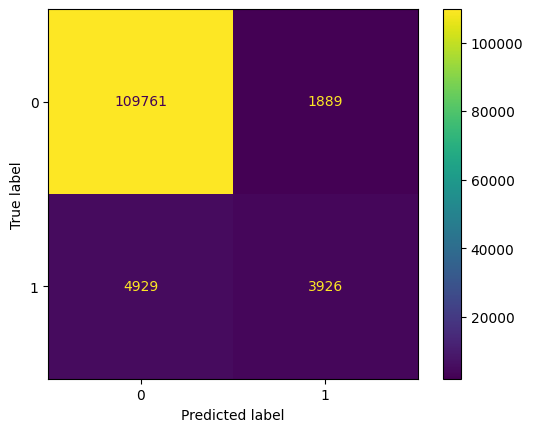

In [91]:
# Create the confusion matrix
cm = confusion_matrix(y_test, predicciones)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [92]:
predicciones = modelo.predict_proba(X)
len(predicciones)

602524

In [93]:
df_predicciones = pd.DataFrame(predicciones)
df_predicciones_aceptar = df_predicciones[1]

In [94]:
len(df_predicciones_aceptar[df_predicciones_aceptar > 0.5])

29260

In [95]:
tabla_con_id_cliente_mas_probabilidad = pd.merge(tabla_con_id_cliente, df_predicciones_aceptar, left_index=True, right_index=True)

tabla_con_id_cliente_mas_probabilidad

,ID_CLIENTE,ANTIGUEDAD,FLAG_ACTIVI,ID_ESTADO,ACEPTADO,CT_CTE,DEBITO_DIR,Suma,RENTA,EDAD,ID_GENERO,ID_REGION_RESIDE,1
0,1375586.0,6.0,1.0,0.0,0.0,1,0,1,87218.10,36.0,1.0,0.0,0.027609
1,1050612.0,35.0,0.0,1.0,0.0,1,0,1,122179.11,23.0,0.0,0.0,0.001681
2,1050613.0,35.0,0.0,1.0,0.0,0,0,1,119775.54,23.0,1.0,0.0,0.001681
3,1050615.0,35.0,0.0,1.0,0.0,1,0,1,22220.04,24.0,1.0,0.0,0.001681
4,1050616.0,35.0,0.0,1.0,0.0,1,0,1,295590.36,24.0,1.0,0.0,0.001681
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602519,899549.0,62.0,0.0,1.0,0.0,0,0,0,97397.16,41.0,1.0,1.0,0.002179
602520,1441442.0,7.0,0.0,1.0,0.0,0,0,0,168445.62,34.0,0.0,0.0,0.002145
602521,1454431.0,6.0,0.0,1.0,0.0,0,0,0,53689.02,24.0,1.0,1.0,0.001681
602522,56812.0,229.0,0.0,1.0,0.0,0,0,0,64404.21,61.0,0.0,0.0,0.002179


In [96]:
tabla_con_id_cliente_mas_probabilidad.to_csv(r'resultados_modelos\Resultados_Boosting_Tree.csv', index=False, header=True)